In [0]:
from __future__ import print_function
from __future__ import division

import datetime
import math
import os

import json
import matplotlib.pyplot as plt
import pandas as pd

def print_columns(strings, max_width=120):
  """Prints a list of strings in columns."""
  padding = 2
  longest = max(len(s) for s in strings)
  max_columns = math.floor((max_width - 1) / (longest + 2 * padding))
  rows = int(math.ceil(len(strings) / max_columns))
  columns = int(math.ceil(len(strings) / rows))  # Might not fill all max_columns.
  for r in range(rows):
    for c in range(columns):
      i = r + c * rows
      if i < len(strings):
        print(" " * padding + strings[i].ljust(longest + padding), end="")
    print()

def load_jsonl_data(filename):
  with open(filename) as f:
    return [json.loads(l) for l in f.readlines()]

def sub_sample(data, count):
  return data[::(max(1, len(data) // count))]

def smooth(data, count):
  for k in data.keys():
    if not k.startswith("time_"):
      data[k] = data[k].rolling(max(1, len(data) // count)).mean()
  return data

def subplot(*args, **kwargs):
  ax = plt.subplot(*args, **kwargs)
  ax.tick_params(top=False, right=False)  # Don't interfere with the titles.
  return ax

def plot_zero(ax):
  df.plot(ax=ax, x=x, y="zero", label="", visible=False)

In [257]:
directory = "/tmp/az-cc"
data = load_jsonl_data(os.path.join(directory, "learner.jsonl"))
with open(os.path.join(directory, "log-config.txt")) as f: 
  print(f.read())
print("data keys:")
print_columns(sorted(data[0].keys()), 150)

[2020-01-15 12:05:06.060] config started
[2020-01-15 12:05:06.060] Config: game: connect_four
path: /tmp/az-cc
graph_def: vpnet.pb
gpu: 1
learning_rate: 0.0001
weight_decay: 0.0001
train_batch_size: 1024
inference_batch_size: 1
inference_threads: 2
inference_cache: 1
replay_buffer_size: 65536
replay_buffer_reuse: 3
checkpoint_freq: 10
evaluation_window: 100
uct_c: 2
max_simulations: 100
policy_alpha: 1
policy_epsilon: 0.25
temperature: 1
actors: 60
evaluators: 4
eval_levels: 7
max_steps: 0

[2020-01-15 12:05:06.060] Closing the log.

data keys:
  cache_hit_rate          cache_usage             eval_count              loss_value              total_states            value_accuracy_6      
  cache_hits              eval_0                  game_length             queue_size              total_trajectories      value_prediction_0    
  cache_max_size          eval_1                  game_length_max         states_per_s            value_accuracy_0        value_prediction_1    
  cache_misses

In [258]:
print("training time:", datetime.timedelta(seconds=int(data[-1]["time_rel"])))
print("training steps: %d" % (data[-1]["step"]))
print("total states: %d" % (data[-1]["total_states"]))
print("total trajectories: %d" % (data[-1]["total_trajectories"]))

df = pd.DataFrame(data)
df = smooth(df, 10)
df = sub_sample(df, 200)
df["time_rel_h"] = df["time_rel"] / 3600
df["zero"] = 0

# x = "time_rel_h"
x = "step"

training time: 1 day, 1:09:45
training steps: 16052
total states: 350880452
total trajectories: 13495204


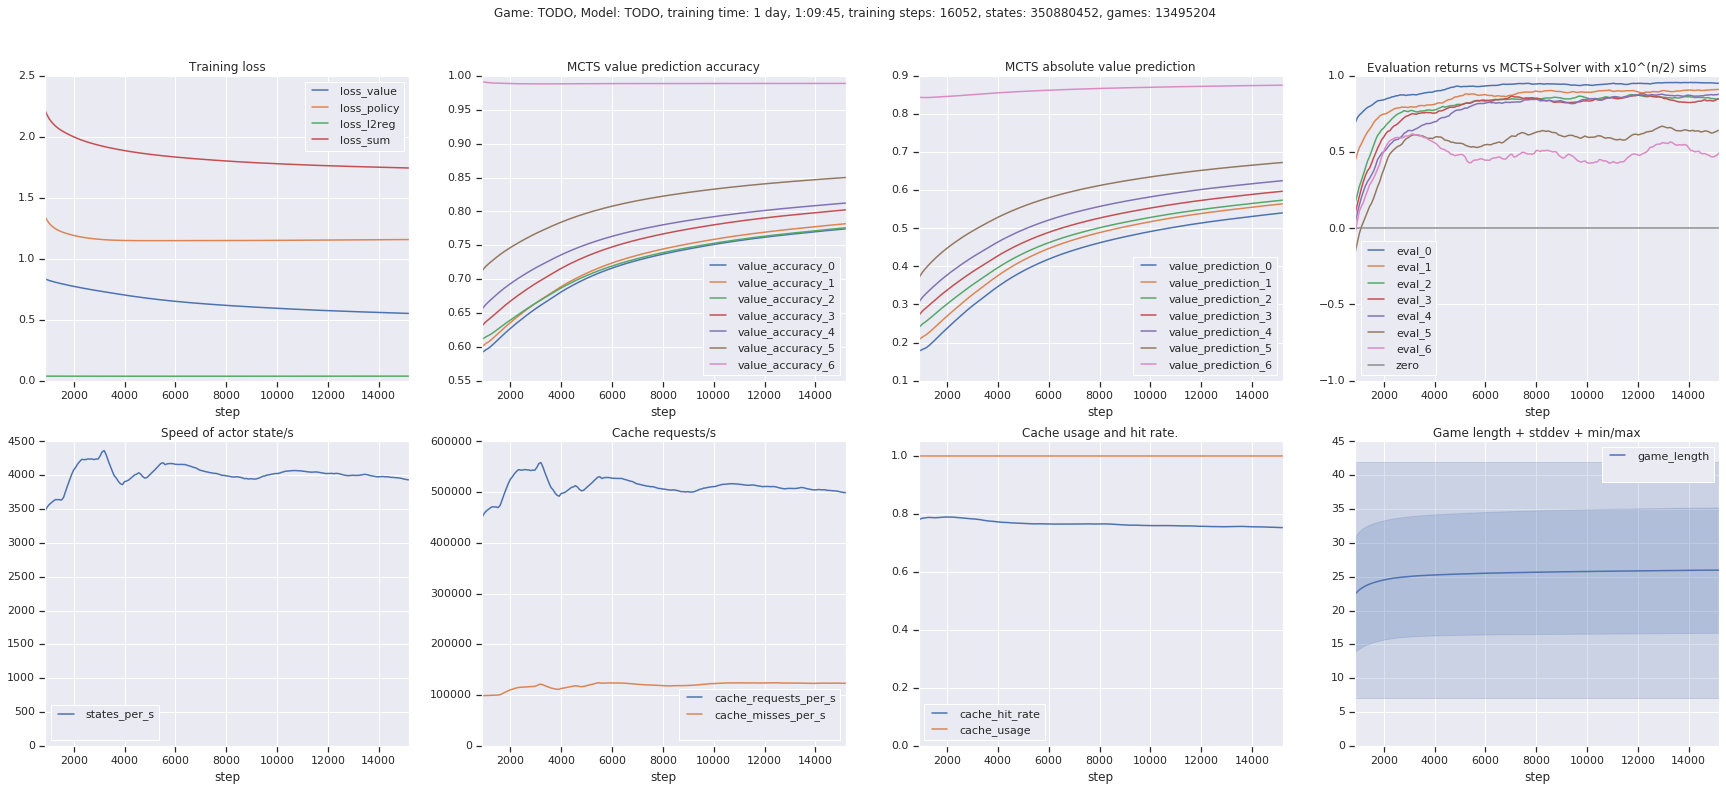

In [259]:
fig = plt.figure(figsize=(30, 12))
fig.suptitle("Game: {}, Model: {}, training time: {}, training steps: {}, states: {}, games: {}".format(
    "TODO", "TODO", datetime.timedelta(seconds=int(data[-1]["time_rel"])), 
    int(data[-1]["step"]), int(data[-1]["total_states"]), 
    int(data[-1]["total_trajectories"])))

ax = subplot(241, title="Training loss")
for y in ['loss_value', 'loss_policy', 'loss_l2reg', 'loss_sum']:
  df.plot(ax=ax, x=x, y=y)

ax = subplot(242, title="MCTS value prediction accuracy")  #, ylim=(0, 1.05))
for i in range(7):
  df.plot(ax=ax, x=x, y='value_accuracy_%s' % i)

ax = subplot(243, title="MCTS absolute value prediction")  #, ylim=(0, 1.05))
for i in range(7):
  df.plot(ax=ax, x=x, y='value_prediction_%s' % i)

ax = subplot(244, title="Evaluation returns vs MCTS+Solver with x10^(n/2) sims", ylim=(-1, 1))
for i in range(7):
  df.plot(ax=ax, x=x, y='eval_%s' % i)
df.plot(ax=ax, x=x, y="zero")

ax = subplot(245, title="Speed of actor state/s")
df.plot(ax=ax, x=x, y='states_per_s')
plot_zero(ax)

ax = subplot(246, title="Cache requests/s")
df.plot(ax=ax, x=x, y="cache_requests_per_s")
df.plot(ax=ax, x=x, y="cache_misses_per_s")
plot_zero(ax)

ax = subplot(247, title="Cache usage and hit rate.", ylim=(0, 1.05))
for y in ['cache_hit_rate', 'cache_usage']:
  df.plot(ax=ax, x=x,y=y)

ax = subplot(248, title="Game length + stddev + min/max")
df.plot(ax=ax, x=x, y='game_length', color='b')
plt.fill_between(x=df[x], color='b', alpha=0.2, label="std dev",
                 y1=(df["game_length"] - df["game_length_stddev"]),
                 y2=(df["game_length"] + df["game_length_stddev"]))
plt.fill_between(x=df[x], color='b', alpha=0.2, label="min/max",
                 y1=df["game_length_min"], y2=df["game_length_max"])
plot_zero(ax)

plt.show()